In [1]:
get_ipython().run_line_magic('matplotlib','notebook')
# get_ipython().run_line_magic('matplotlib','inline')
get_ipython().run_line_magic('load_ext','autoreload')
get_ipython().run_line_magic('autoreload', '2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


/albedo/home/pscholz/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [3]:
# Parameters
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_norim/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_pengyang_cavity_core2/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'hslice'

vname     = ''
year      = [1979, 2019]
mon, day, record, box, depth = None, None, None, None, 1000
box       = [-180, 180, -90, -65]
#_____________________________________________________________________________________
cstr, cnum = 'blue2red', 20
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2 
do_rescale= None #'log10'
which_dpi = 300
proj      = 'sps'
do_plot   = 'tpc'
do_reffig = True
figfac    = [10,10] #ä[7, 3.5]

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=False, do_cavity=True, do_loadraw=True)

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)


 > load mesh from *.out files: /albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test
 > comp e_area
 > comp n_area
 > compute lsmask


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:1786: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  self.obj[key] = infer_fill_value(value)


 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test/tripyview_fesom2_help_macaspel_rglobi_117test_pbnd.shp
 > augment lsmask


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:1786: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  self.obj[key] = infer_fill_value(value)


 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test/tripyview_fesom2_help_macaspel_rglobi_117test_focus=0.shp
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test
 > id              = help_macaspel_rglobi_117test
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = True
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 1074800
 > #elem           = 2115935
 > #lvls           = 117
___________________________________________


## <ins> Load/Plot cavity elemental vertical boundary index <ins>
In the model corresponds to the variable ulevels(elem)    
- load cavity boundary index on elements before the constrains (elemental ocean prisms are not allowed to have three boundary nodes, <br>
  there must be always at least three valid ocean layers, no isolated nodes are allowed in the vertical) are imposed e_ic_raw (cavity_elvls_raw.out)
- load cavity boundary index on elements after the constrains are imposed e_ic (cavity_elvls.out)    

In [5]:
# load e_ic_raw
datac0 = xr.Dataset(data_vars=dict(e_i=(['elem'], mesh.e_ic_raw.astype('float32'), dict({'descript':'e_ic_raw', 'long_name':'raw cav. elem idx', 'units':''}))),
                 coords=dict(elem=('elem', np.arange(0,mesh.n2de)))).chunk(chunks={'elem':1e4})
datac0, dum, dum = tpv.do_gridinfo_and_weights(mesh,datac0,do_zweight=False)

# load e_ic
datac1 = xr.Dataset(data_vars=dict(e_i=(['elem'], mesh.e_ic.astype('float32'), dict({'descript':'e_ic', 'long_name':'cav. elem idx', 'units':''}))),
                 coords=dict(elem=('elem', np.arange(0,mesh.n2de)))).chunk(chunks={'elem':1e4})
datac1, dum, dum = tpv.do_gridinfo_and_weights(mesh,datac1,do_zweight=False)

# load e_ic - e_ic_raw
datac10 = tpv.do_anomaly(datac1, datac0)

[-180, 180, -90, -65]


<IPython.core.display.Javascript object>


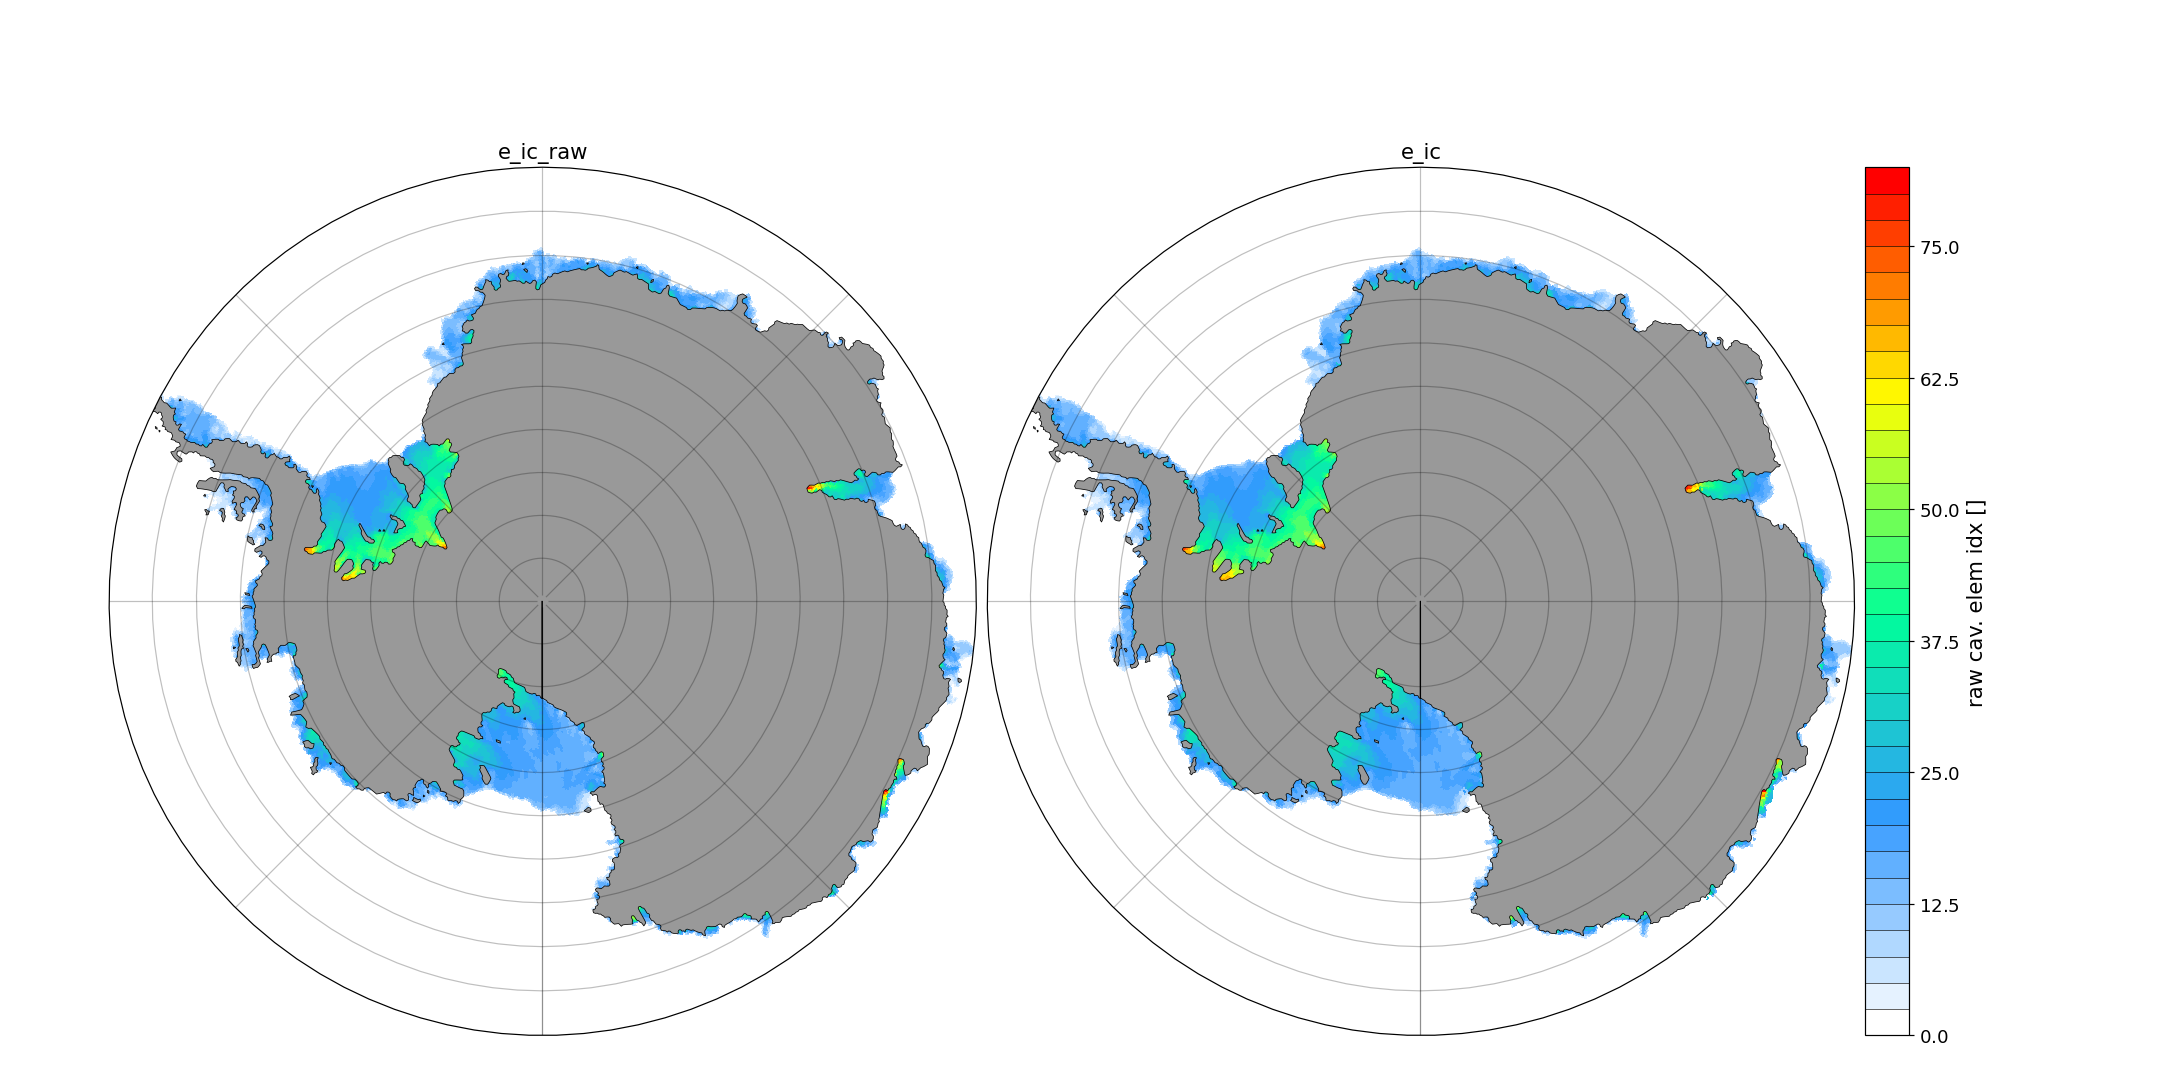

--> do triangulation:  0.13959360122680664
{'cstr': 'wbgyr', 'cmin': 0, 'cmax': dask.array<amax-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>, 'chist': False, 'ctresh': 0.995, 'cref': dask.array<around, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>, 'cnum': 20, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbaca79ceb0>, 'clevel': array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
       27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5,
       55. , 57.5, 60. , 62.5, 65. , 67.5, 70. , 72.5, 75. , 77.5, 80. ,
       82.5])}
--> do setup cinfo:  1.1813616752624512
--> do scaling norm:  1.7642974853515625e-05
--> do augment data:  0.3585848808288574
--> do tripcolor:  0.8936672210693359
--> do lsmask:  0.0007982254028320312
--> do gridlines:  0.0007088184356689453
--> do augment data:  0.5188980102539062
--> do tripcolor:  0.5405445098876953
--> do lsmask:  0.001439809799194336
--> do gridlines:  

<IPython.core.display.Javascript object>


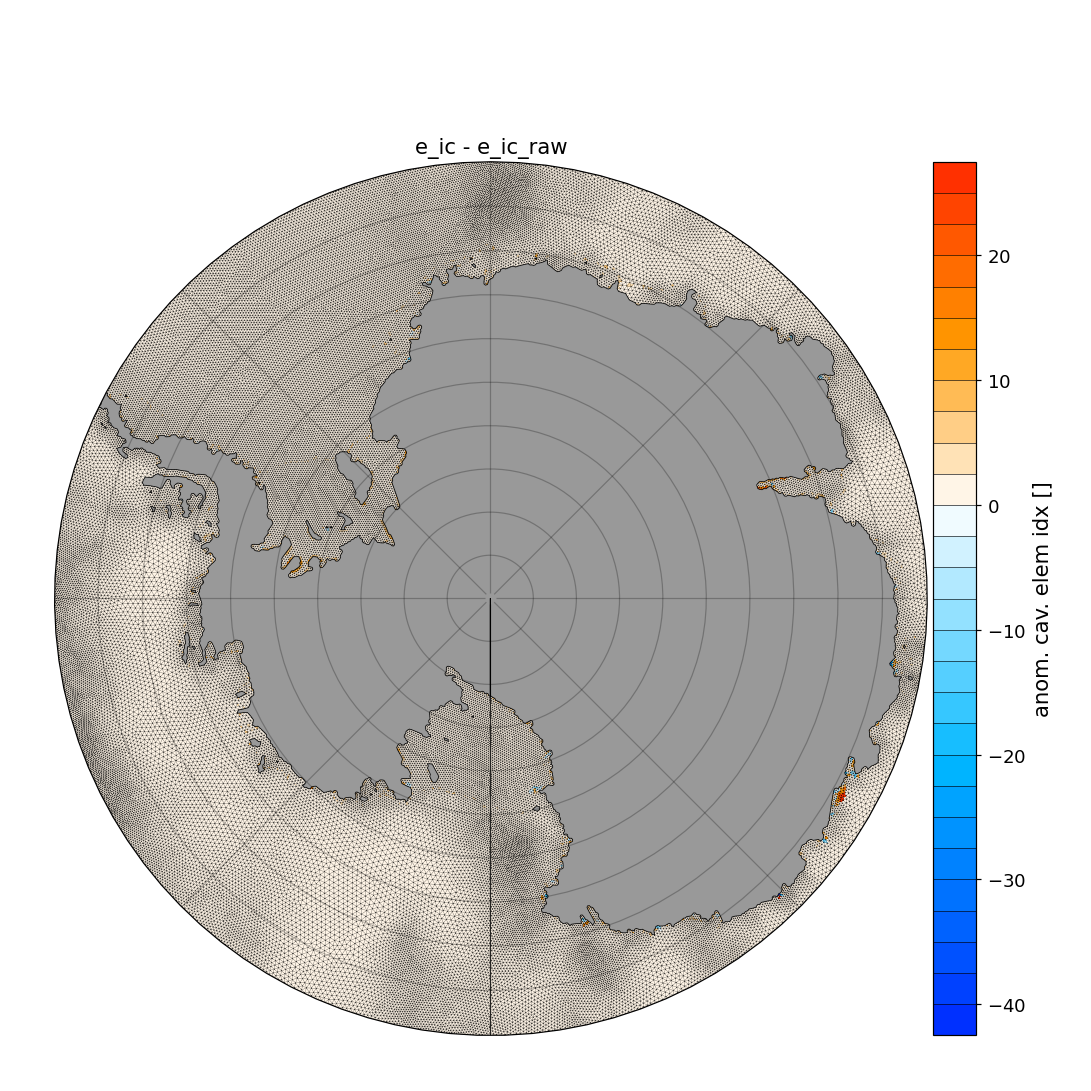

--> do triangulation:  0.131791353225708
{'cstr': 'blue2red', 'cmin': dask.array<amin-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>, 'cmax': dask.array<amax-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>, 'cref': 0, 'cstep': 1, 'chist': False, 'ctresh': 0.995, 'cnum': 20, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fba863aac10>, 'clevel': array([-42.5, -40. , -37.5, -35. , -32.5, -30. , -27.5, -25. , -22.5,
       -20. , -17.5, -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,
         2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,
        25. ,  27.5])}
--> do setup cinfo:  2.069556474685669
--> do scaling norm:  7.867813110351562e-06
--> do augment data:  0.371204137802124
--> do tripcolor:  0.9379153251647949
--> do triplot:  0.04727911949157715
--> do lsmask:  0.0006635189056396484
--> do gridlines:  0.0006678104400634766


In [16]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(datac0.keys())[0]
if spath != None: spath  = os.path.join(spath,'{}_{}.png'.format(which_mode, sname)) 
if save_fname != None: spath = save_fname

pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02] 
cinfo = dict({'cstr':'wbgyr', 'cmin':0, 'cmax':datac0[sname].data.max(), 'chist':False})
fig, ax, cbar = tpv.plot_hslice(mesh, [datac0, datac1], cinfo=cinfo, box=box, n_rc=[1, 2], 
                            figsize=[2*figfac[0], figfac[1]], proj = proj, do_plot = do_plot,
                            do_lsmask='fesom', do_rescale=do_rescale, title='descript', do_grid=False,
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi, do_info=True, do_ie2n=False)

#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(datac10.keys())[0]
if spath != None: spath  = os.path.join(spath,'{}_{}.png'.format(which_mode, sname)) 
if save_fname != None: spath = save_fname
pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02] 
cinfo = dict({'cstr':'blue2red', 'cmin':datac10[sname].data.min(), 'cmax':datac10[sname].data.max(), 'cref':0, 'cstep':1, 'chist':False})
fig, ax, cbar = tpv.plot_hslice(mesh, [datac10], cinfo=cinfo, box=box, n_rc=[1, 1], 
                            figsize=[figfac[0], figfac[1]], proj = proj, do_plot = do_plot,
                            do_lsmask='fesom', do_rescale=do_rescale, title='descript', do_grid=True,
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi, do_info=True, do_ie2n=False)

## <ins> Load/Plot bottom elemental vertical boundary index <ins>
- load bottom boundary index on elements before the constrains (elemental ocean prisms are not <br> 
  allowed to have three boundary nodes) are imposed e_iz_raw (elvls_raw.out)
- load bottom boundary index on elements after the constrains are imposed e_iz (elvls.out)    

In [7]:
# load e_iz_raw
dataz0 = xr.Dataset(data_vars=dict(e_i=(['elem'], mesh.e_iz_raw.astype('float32'), dict({'descript':'e_iz_raw', 'long_name':'raw bottom elem idx', 'units':''}))),
                 coords=dict(elem=('elem', np.arange(0,mesh.n2de)))).chunk(chunks={'elem':1e4})
dataz0, dum, dum = tpv.do_gridinfo_and_weights(mesh,dataz0,do_zweight=False)

# load e_iz
dataz1 = xr.Dataset(data_vars=dict(e_i=(['elem'], mesh.e_iz.astype('float32'), dict({'descript':'e_iz', 'long_name':'bottom elem idx', 'units':''}))),
                 coords=dict(elem=('elem', np.arange(0,mesh.n2de)))).chunk(chunks={'elem':1e4})
dataz1, dum, dum = tpv.do_gridinfo_and_weights(mesh,dataz1,do_zweight=False)

# load e_iz - e_iz_raw
dataz10 = tpv.do_anomaly(dataz1, dataz0)

[-180, 180, -90, -65]


<IPython.core.display.Javascript object>


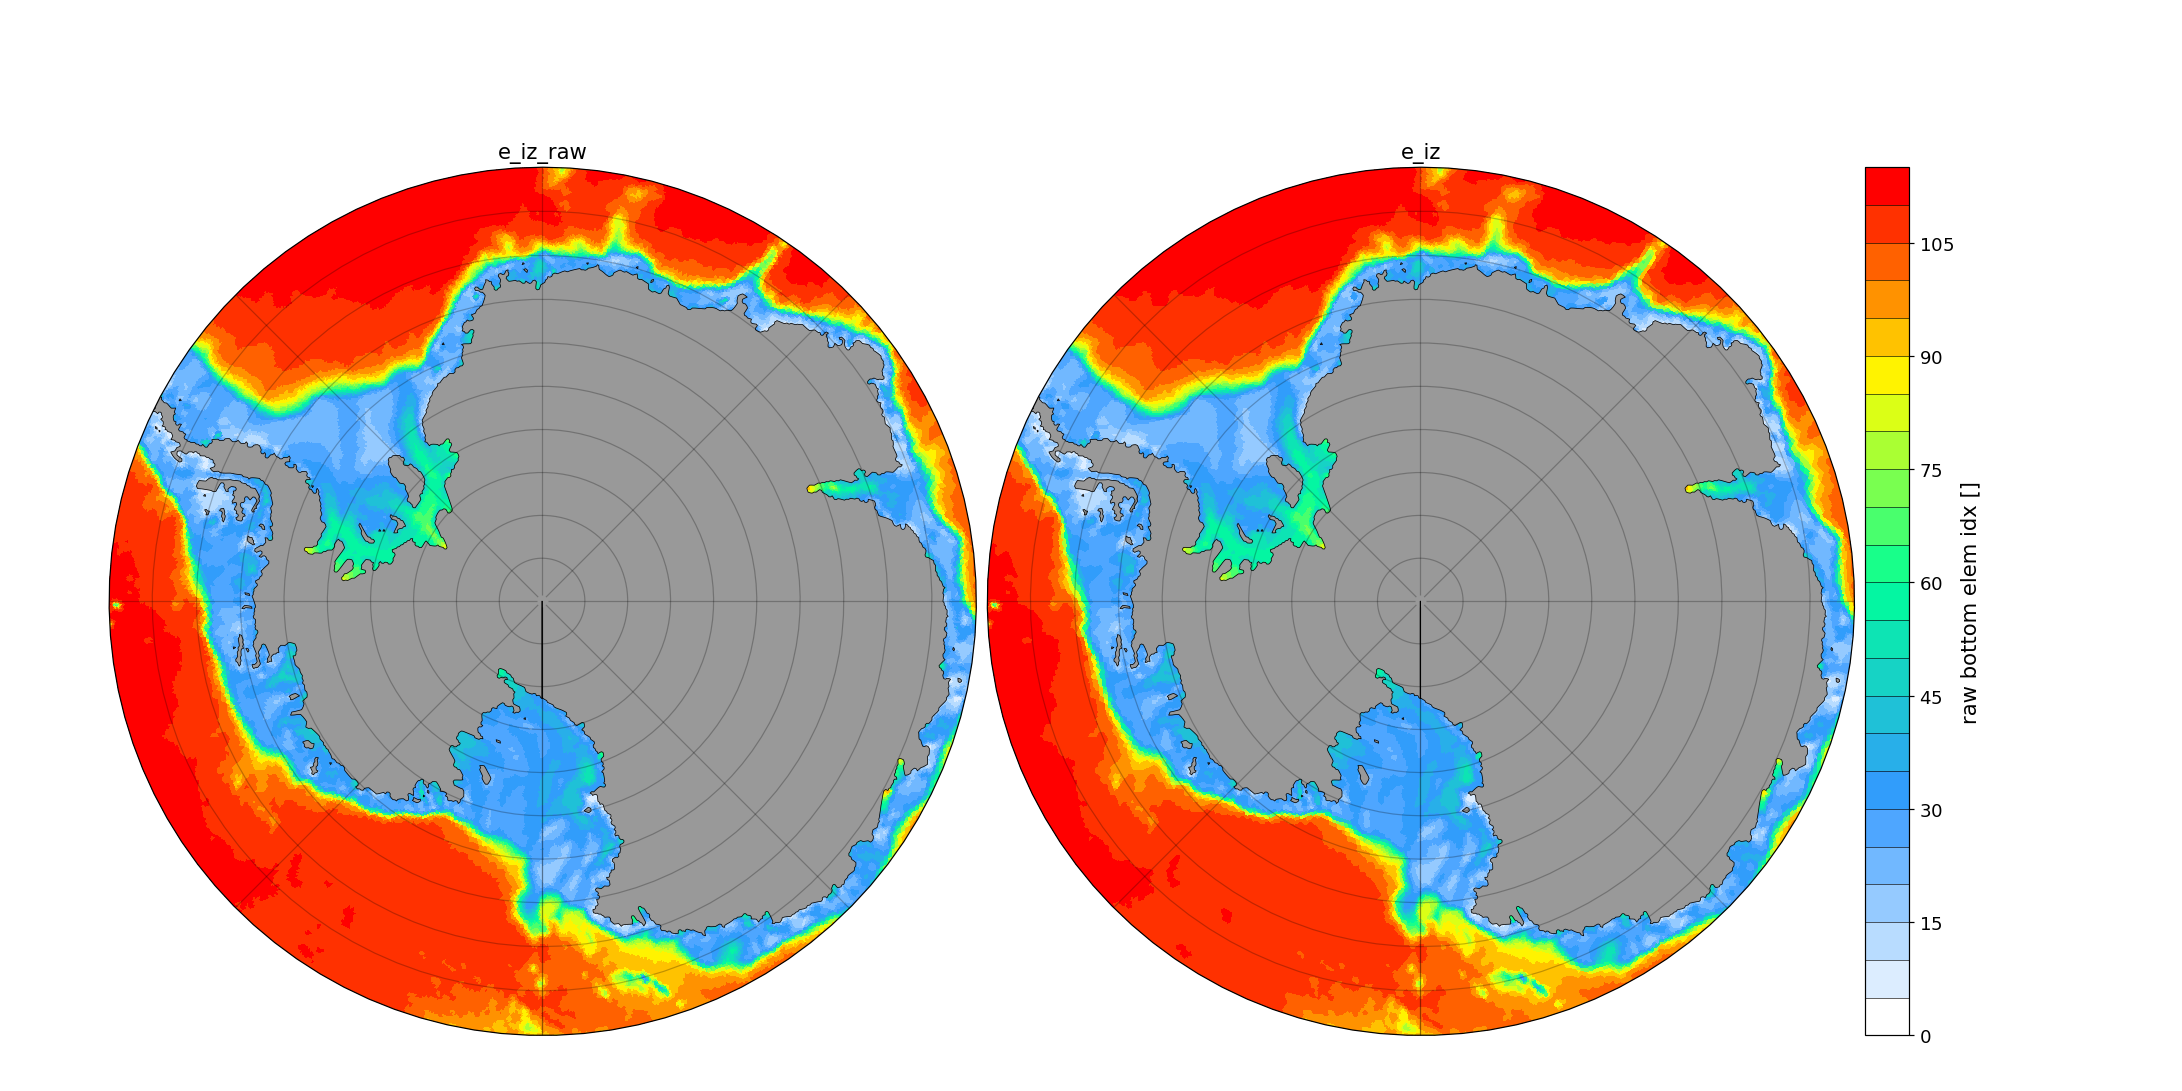

--> do triangulation:  0.13558483123779297
{'cstr': 'wbgyr', 'cmin': 0, 'cmax': dask.array<amax-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>, 'chist': False, 'ctresh': 0.995, 'cref': dask.array<around, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>, 'cnum': 20, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbcb6d111f0>, 'clevel': array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115.])}
--> do setup cinfo:  1.2121851444244385
--> do scaling norm:  3.814697265625e-06
--> do augment data:  0.358914852142334
--> do tripcolor:  0.5330235958099365
--> do lsmask:  0.0008618831634521484
--> do gridlines:  0.0006749629974365234
--> do augment data:  0.5088703632354736
--> do tripcolor:  1.0061326026916504
--> do lsmask:  0.0007815361022949219
--> do gridlines:  0.0007088184356689453
[-180, 180, -90, -65]


<IPython.core.display.Javascript object>


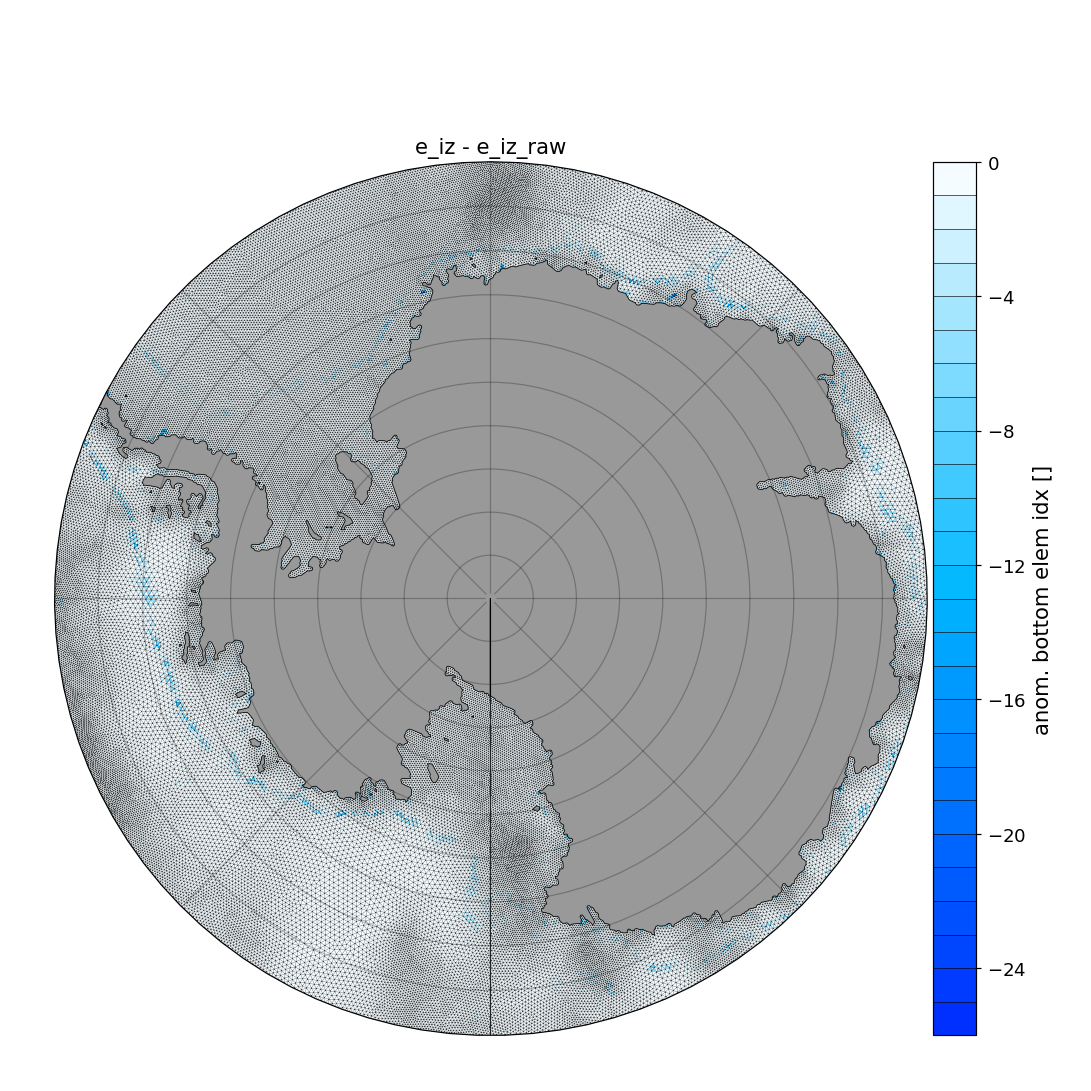

--> do triangulation:  0.12389469146728516
{'cstr': 'blue2red', 'cmin': dask.array<amin-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>, 'cmax': dask.array<amax-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>, 'cref': 0, 'cstep': 1, 'chist': False, 'ctresh': 0.995, 'cnum': 20, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbcb78e97f0>, 'clevel': array([-26., -25., -24., -23., -22., -21., -20., -19., -18., -17., -16.,
       -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,
        -4.,  -3.,  -2.,  -1.,   0.])}
--> do setup cinfo:  1.9846861362457275
--> do scaling norm:  2.6226043701171875e-06
--> do augment data:  0.3651919364929199
--> do tripcolor:  0.7531325817108154
--> do triplot:  0.045081138610839844
--> do lsmask:  0.0006465911865234375
--> do gridlines:  0.0008864402770996094


In [17]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(dataz0.keys())[0]
if spath != None: spath  = os.path.join(spath,'{}_{}.png'.format(which_mode, sname)) 
if save_fname != None: spath = save_fname

pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02] 
cinfo = dict({'cstr':'wbgyr', 'cmin':0, 'cmax':dataz0[sname].data.max(), 'chist':False})
fig, ax, cbar = tpv.plot_hslice(mesh, [dataz0, dataz1], cinfo=cinfo, box=box, n_rc=[1, 2], 
                            figsize=[2*figfac[0], figfac[1]], proj = proj, do_plot = do_plot,
                            do_lsmask='fesom', do_rescale=do_rescale, title='descript', do_grid=False,
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi, do_info=True, do_ie2n=False)

#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(dataz10.keys())[0]
if spath != None: spath  = os.path.join(spath,'{}_{}.png'.format(which_mode, sname)) 
if save_fname != None: spath = save_fname
pos_gap = [0.005, 0.04]
if   proj in ['nps, sps']:pos_gap = [0.005, 0.035] 
elif proj in ['rob']     :pos_gap = [0.005, -0.02] 
cinfo = dict({'cstr':'blue2red', 'cmin':dataz10[sname].data.min(), 'cmax':dataz10[sname].data.max(), 'cref':0, 'cstep':1, 'chist':False})
fig, ax, cbar = tpv.plot_hslice(mesh, [dataz10], cinfo=cinfo, box=box, n_rc=[1, 1], 
                            figsize=[figfac[0], figfac[1]], proj = proj, do_plot = do_plot,
                            do_lsmask='fesom', do_rescale=do_rescale, title='descript', do_grid=True,
                            pos_gap=pos_gap, pos_extend=[0.05, 0.05, 0.85, 0.90], 
                            do_save=spath, save_dpi=which_dpi, do_info=True, do_ie2n=False)